In [108]:
from joblib import dump, load
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [118]:
df1 = pd.read_csv('archive/lap_times.csv')
df2 = pd.read_csv('archive/races.csv')

In [119]:
#Eldobjuk a position és az ido oszlopot, és millisecond-al dolgozunk
df1 = df1.drop('time', axis=1)
df1 = df1.drop('position', axis=1)
#Eldobjuk a 2010 előtti versenyeket, mivel 2010be tiltották meg a tankolást,
df2 = df2[df2['year'] > 2009]
#Eldobunk további felesleges oszlopokat
df2 = df2.drop(['round','round','date','time','url','fp1_date','fp1_time',
'fp2_date','fp2_time','fp3_date','fp3_time','quali_date','quali_time', 'sprint_date', 'sprint_time'], axis=1)

In [120]:
merged_df = pd.merge(df1, df2, on='raceId', how='inner')

In [121]:
#Leszűkítjük a keresést Hamiltonra
Ham = merged_df[(merged_df['driverId'] == 1)]

In [122]:
median = Ham['milliseconds'].median()
print(median)
Ham['milliseconds'] = np.where(Ham['milliseconds'] > median, median - 3000, Ham['milliseconds'])

#Kiválasztjuk Monza-t
Ham = Ham[(Ham['circuitId'] == 14)]

92793.0


C:\Users\prokk\AppData\Local\Temp\ipykernel_4432\279433133.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Ham['milliseconds'] = np.where(Ham['milliseconds'] > median, median - 3000, Ham['milliseconds'])


In [123]:
#Válasszuk ki azokat a változókat, amelyeket a predikcióhoz használunk
X = Ham[['raceId', 'lap', 'year']]
y = Ham['milliseconds']

In [132]:
#Felbontjuk az adatokat tanító és teszt adathalmazokra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Létrehozunk egy DecisionTreeRegressor modellt
model = DecisionTreeRegressor()

#Tanítjuk a modellt a tanító adatokon
model.fit(X_train, y_train)

#Elmentjük a tanított modelt
if not os.path.exists('models'):
    os.mkdir('models')

dump(model, 'models/Formula1_DecisionTreeModel.joblib') 

['models/Formula1_DecisionTreeModel.joblib']

In [133]:
# Predikciók a validációs adathalmazon
preds = model.predict(X_test)

# Számoljuk ki az átlagos abszolút hibát
mae = mean_absolute_error(y_test, preds)
mse = mean_squared_error(y_test,preds)
print(f'MSE: {mse}, MAE: {mae}')

MSE: 1280314.0655737706, MAE: 656.8852459016393


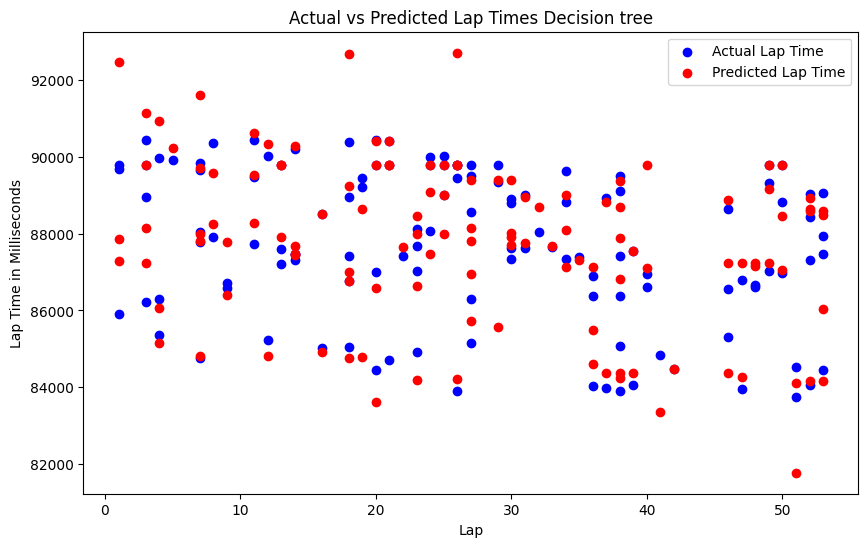

In [135]:
# Predikciók és valós adatok plotolása
plt.figure(figsize=(10,6))

plt.scatter(X_test['lap'], y_test, color = 'blue', label = 'Actual Lap Time')
plt.scatter(X_test['lap'], preds, color = 'red', label = 'Predicted Lap Time')
plt.title('Actual vs Predicted Lap Times Decision tree')
plt.xlabel('Lap')
plt.ylabel('Lap Time in Milliseconds')
plt.legend()
plt.show()